# JB 데이터 분석 경진대회
___

고객은 상품 구매 시, <u><b>개인의 취향</b></u> 및 <u><b>필요</b></u>에 따라 각기 구분되는 소비패턴을 보임.

고객의 과거 상품 구매 이력을 통해 소비패턴을 발견하여 미래 소비를 예측하고자 하는 시도는 산업 전반에서 이루어져 왔음.

고객의 미래 소비를 예측하고, <u><b>개인화된 제안</u></b>을 하는 것에 역량을 집중하여 성공한 기업들로 구글, 넷플릭스 등이 있음.

한편, 온라인 커머스에서 고객이 상품을 구매할 때에, 하나 이상의 여러 상품을 한 주문서에 담아서 주문하는 것이 일반적임.

고객이 주문서에 상품을 담을 때에, 과거 이력을 통해 고객이 재구매 할만한 상품을 제안하여 고객 경험을 제고할 수 있음.

본 대회의 주제는 <b><u>온라인 커머스 상품 제안</b></u>이며, 현재 고객별 재구매율이 높은 상품을 제안하기 위해 <b><u>다양한 분석을 시도</b></u>하고 <b><u>우수한 예측 결과</b></u>를 도출하는 것을 목표로 함.


___
## Step 0. 분석 환경 설정 및 패키지 입수

In [2]:
from jbfg.pandas_utils import *
import pandas as pd
import pickle
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import time
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler

In [3]:
schema = 'l2_jbwc_extnl'

In [4]:
pd.set_option('display.max_rows', 30)

___
## Step 1. 테이블 메타 확인

> 테이블 목록

<img>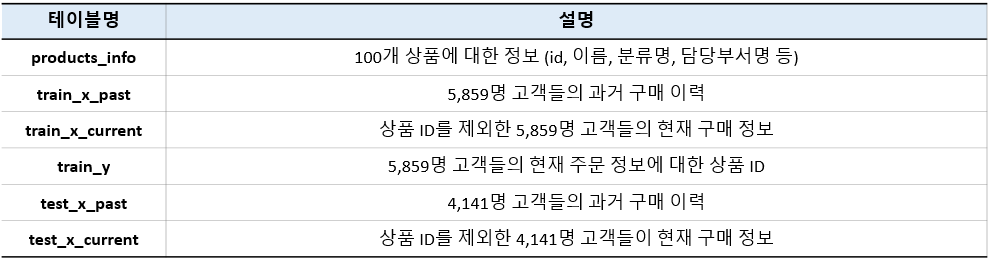</img>

> 필드 설명

<img>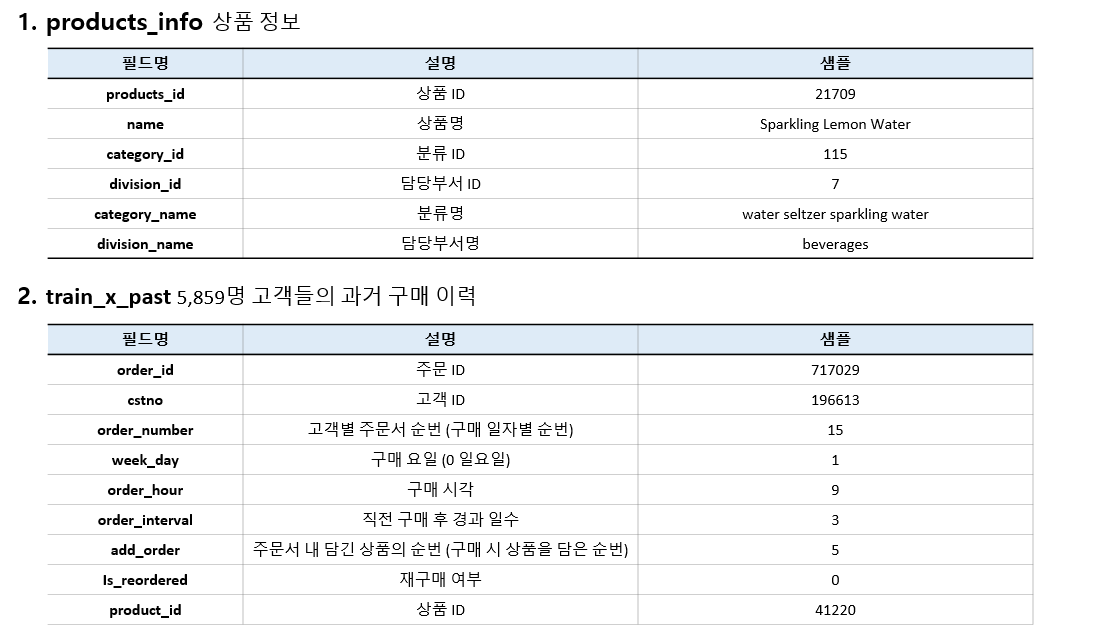</img>

> 테이블 레이아웃만 확인하면 되니까 시점 및 분할데이터정보는 무시  
___

___
## Step 2. 분석 컨셉 

> "사용자" 에 초점을 둔 협업필터링, "컨텐츠" 에 초점을 둔 컨텐츠 기반 추천 두 가지 방식을 고려 , 아래 두 가지 가정을 기본 전제로 진행

    - 동일한 물건을 구입한 고객은 비슷한 구매 취향이 있을 것 
    - 개인의 특정 물건에 대한 구매 패턴이 있을 것  

> 위 두 가지 전제를 통해 고객군의 구매 예상물품군을 선정하고 개인의 구매 패턴을 통해 최종 결과를 도출하자.

> EDA 후..  분석 설계  
- 분석의 목적이 추천이 아님. 고객은 구매를 했고, 구매한 품목을 예측 하는 것이 목표  
- 구매 이력이나 내역이 모두 포함되어 있지 않으므로, 재구매 빈도는 상품에 한정된 항목이 아닌 고객의 특성으로 판단해야 함  
- 주문 단위에서 유사한 주문을 판단하여 주문별 성격을 군집화 해보고  
- 고객 단위에서 구매 내역을 판단하여 고객별 성격을 군집화 해보고  
- 100가지 pool 에서 추정이 아닌 고객 세그먼트별로 타겟 변수 품목을 줄여서 작업 진행  
- 재구매 품목과 아닌 품목에 대해서 별도의 추정작업이 필요. 재구매 품목은 완전한 데이터가 아니더라도 개인에 따라 추정을 한다 가정하고, 아닌 경우 동일 고객군단위에서 구매비중이 높은 품목으로 추정 

___
## Step 3. 데이터 입수 및 탐색

### Step 3-1. 무얼 파는 회사인가?  
> 식료품 판매를 하는 회사로, 상품비중은 농산품이 매우 높음.  
그러나 농산품 특성상 카테고리가 세분화되있을 수 있으므로 실제 구입비중 등을 확인해야 할 것으로 판단  
데이터 하나가 잘못들어가 있어서 수정 작업 진행 후 데이터 저장 완료

In [7]:
sql = "select * from products_info"
gds_df = get_df(sql, schema)

In [8]:
gds_df.describe()

,product_id,name,category_id,division_id,category_name,division_name
count,100,100,100,100,100,100
unique,100,100,21,9,21,9
top,28199,Yellow Onions,83,4,fresh vegetables,produce
freq,1,1,29,67,29,67


> 총 22개 카테고리로 나눠져 있고 100개의 상품이 있음. 담당부서단위는 왠지 카테고리 상위계층일 것 같으니 좀 더 보는거로

In [9]:
pd.pivot_table(gds_df, index = ['division_name'], aggfunc = 'count').sort_values(by = 'product_id', ascending = False)

,category_id,category_name,division_id,name,product_id
division_name,,,,,
produce,67,67,67,67,67
dairy eggs,18,18,18,18,18
beverages,7,7,7,7,7
deli,2,2,2,2,2
frozen,2,2,2,2,2
bakery,1,1,1,1,1
canned goods,1,1,1,1,1
meat seafood,1,1,1,1,1
pantry,1,1,1,1,1


> 판매물품의 담당부서 단위로 보았을 때 신선식품 위주의 판매를 하는 업체 같음  
초창기 컬리같은 걸까, 영어가 약해서 한글로 적어둠 

In [10]:
gds_df['div_kor'] = gds_df['division_name'].map({'pantry':'저장소','dairy eggs': '유제품 및 계란', 'frozen':'냉동식품',
                                                 'produce':'농산품','beverages':'음료',
                                                 'deli':'간편식품','bakery':'빵','canned goods':'통조림',
                                                 'meat seafood' : '고기/해산물', 'packaged vegetables fruits':'포장채소'})

In [11]:
pd.pivot_table(gds_df, index = ['div_kor', 'category_name'], aggfunc = 'count').sort_index()

category_id  division_id  \
div_kor  category_name                                             
간편식품     fresh dips tapenades                     1            1   
         lunch meat                               1            1   
고기/해산물   packaged poultry                         1            1   
냉동식품     frozen produce                           2            2   
농산품      fresh fruits                            24           24   
         fresh herbs                              3            3   
         fresh vegetables                        29           29   
         packaged produce                         2            2   
         packaged vegetables fruits               9            9   
빵        bread                                    1            1   
유제품 및 계란 butter                                   2            2   
         cream                                    2            2   
         eggs                                     2            2   
         milk                                     5            5   
         packaged cheese                          4            4   
         soy lactosefree                          3            3   
음료       refrigerated                             1            1   
         soft drinks                              1            1   
         water seltzer sparkling water            5            5   
저장소      oils vinegars                            1            1   
통조림      canned meals beans                       1            1   

                                        division_name  name  product_id  
div_kor  category_name                                                   
간편식품     fresh dips tapenades                       1     1           1  
         lunch meat                                 1     1           1  
고기/해산물   packaged poultry                           1     1           1  
냉동식품     frozen produce                             2     2           2  
농산품      fresh fruits                              24    24          24  
         fresh herbs                                3     3           3  
         fresh vegetables                          29    29          29  
         packaged produce                           2     2           2  
         packaged vegetables fruits                 9     9           9  
빵        bread                                      1     1           1  
유제품 및 계란 butter                                     2     2           2  
         cream                                      2     2           2  
         eggs                                       2     2           2  
         milk                                       5     5           5  
         packaged cheese                            4     4           4  
         soy lactosefree                            3     3           3  
음료       refrigerated                               1     1           1  
         soft drinks                                1     1           1  
         water seltzer sparkling water              5     5           5  
저장소      oils vinegars                              1     1           1  
통조림      canned meals beans                         1     1           1

> 카테고리명이 잘못들어간것 같은 데이터가 보임.  
확인 진행

> 데이터 테이블 바뀌면서 처리된듯 (10.14)

In [12]:
gds_df[gds_df['category_name'] == '4'].T

""
product_id
name
category_id
division_id
category_name
division_name
div_kor


> 분리기호가 잘못 인식 된 것으로 보임.  
한칸씩 옮겨서 데이터 재정비 진행, 해당 category_name 은 "농산품" division_name 으로 재매핑 필요

In [13]:
tmp_dict = {'product_id' : '28199', 'name' : 'Clementines Bag', 'category_id' : '123','division_id' : '4', 
            'category_name' : 'packaged vegetables fruits','division_name' : 'produce', 'div_kor' : '농산품'}
gds_df = pd.concat([gds_df, pd.DataFrame([tmp_dict])], 0) 
gds_df = gds_df[gds_df['category_name'] != '4']

In [14]:
gds_df

,product_id,name,category_id,division_id,category_name,division_name,div_kor
0,21709,Sparkling Lemon Water,115,7,water seltzer sparkling water,beverages,음료
1,20995,Organic Broccoli Florets,116,1,frozen produce,frozen,냉동식품
2,33000,Pure Irish Butter,36,16,butter,dairy eggs,유제품 및 계란
3,7781,Organic Sticks Low Moisture Part Skim Mozzarel...,21,16,packaged cheese,dairy eggs,유제품 및 계란
4,47144,Unsweetened Original Almond Breeze Almond Milk,91,16,soy lactosefree,dairy eggs,유제품 및 계란
...,...,...,...,...,...,...,...
96,21903,Organic Baby Spinach,123,4,packaged vegetables fruits,produce,농산품
97,21137,Organic Strawberries,24,4,fresh fruits,produce,농산품
98,13176,Bag of Organic Bananas,24,4,fresh fruits,produce,농산품
99,24852,Banana,24,4,fresh fruits,produce,농산품


In [15]:
pd.pivot_table(gds_df, index = ['div_kor','category_name'], aggfunc = 'count')

category_id  division_id  \
div_kor  category_name                                             
간편식품     fresh dips tapenades                     1            1   
         lunch meat                               1            1   
고기/해산물   packaged poultry                         1            1   
냉동식품     frozen produce                           2            2   
농산품      fresh fruits                            24           24   
         fresh herbs                              3            3   
         fresh vegetables                        29           29   
         packaged produce                         2            2   
         packaged vegetables fruits              10           10   
빵        bread                                    1            1   
유제품 및 계란 butter                                   2            2   
         cream                                    2            2   
         eggs                                     2            2   
         milk                                     5            5   
         packaged cheese                          4            4   
         soy lactosefree                          3            3   
음료       refrigerated                             1            1   
         soft drinks                              1            1   
         water seltzer sparkling water            5            5   
저장소      oils vinegars                            1            1   
통조림      canned meals beans                       1            1   

                                        division_name  name  product_id  
div_kor  category_name                                                   
간편식품     fresh dips tapenades                       1     1           1  
         lunch meat                                 1     1           1  
고기/해산물   packaged poultry                           1     1           1  
냉동식품     frozen produce                             2     2           2  
농산품      fresh fruits                              24    24          24  
         fresh herbs                                3     3           3  
         fresh vegetables                          29    29          29  
         packaged produce                           2     2           2  
         packaged vegetables fruits                10    10          10  
빵        bread                                      1     1           1  
유제품 및 계란 butter                                     2     2           2  
         cream                                      2     2           2  
         eggs                                       2     2           2  
         milk                                       5     5           5  
         packaged cheese                            4     4           4  
         soy lactosefree                            3     3           3  
음료       refrigerated                               1     1           1  
         soft drinks                                1     1           1  
         water seltzer sparkling water              5     5           5  
저장소      oils vinegars                              1     1           1  
통조림      canned meals beans                         1     1           1

> 이제 데이터 제대로 들어간 것 같음..  
한번 더 눈으로 확인 진행 

In [16]:
gds_df.sort_values(['division_id','category_id'])

,product_id,name,category_id,division_id,category_name,division_name,div_kor
1,20995,Organic Broccoli Florets,116,1,frozen produce,frozen,냉동식품
50,9076,Blueberries,116,1,frozen produce,frozen,냉동식품
43,25890,Boneless Skinless Chicken Breasts,49,12,packaged poultry,meat seafood,고기/해산물
42,31506,Extra Virgin Olive Oil,19,13,oils vinegars,pantry,저장소
18,27156,Organic Black Beans,59,15,canned meals beans,canned goods,통조림
...,...,...,...,...,...,...,...
35,35221,Lime Sparkling Water,115,7,water seltzer sparkling water,beverages,음료
51,19660,Spring Water,115,7,water seltzer sparkling water,beverages,음료
74,44632,Sparkling Water Grapefruit,115,7,water seltzer sparkling water,beverages,음료
17,3957,100% Raw Coconut Water,31,7,refrigerated,beverages,음료


> 데이터는 제대로 들어간것 같으니, 카테고리도 한글로 좀 보기 편하게.. 상품명은 안건드림

In [17]:
np.unique(gds_df['category_name'])

array(['bread', 'butter', 'canned meals beans', 'cream', 'eggs',
       'fresh dips tapenades', 'fresh fruits', 'fresh herbs',
       'fresh vegetables', 'frozen produce', 'lunch meat', 'milk',
       'oils vinegars', 'packaged cheese', 'packaged poultry',
       'packaged produce', 'packaged vegetables fruits', 'refrigerated',
       'soft drinks', 'soy lactosefree', 'water seltzer sparkling water'],
      dtype=object)

In [18]:
tmp_dict = {'bread':'빵',
'butter':'버터',
'canned meals beans':'콩통조림',
'cream':'크림',
'eggs':'달걀',
'fresh dips tapenades':'샌드위치',
'fresh fruits':'신선과일',
'fresh herbs':'신선허브',
'fresh vegetables':'신선야채',
'frozen produce':'냉동농산품',
'lunch meat':'육류가공품',
'milk':'우유',
'oils vinegars':'기름식초',
'packaged cheese':'포장치즈',
'packaged poultry':'포장가금류',
'packaged produce':'포장농산품',
'packaged vegetables fruits':'포장과일',
'refrigerated':'냉장음료',
'soft drinks':'청량음료', 
'soy lactosefree':'두유/락토프리', 
'water seltzer sparkling water' : '탄산수'}
gds_df['cat_kor'] = gds_df['category_name'].map(tmp_dict)

In [19]:
pd.pivot_table(gds_df, index = ['div_kor','cat_kor'], aggfunc = 'count')

category_id  category_name  division_id  division_name  \
div_kor  cat_kor                                                           
간편식품     샌드위치               1              1            1              1   
         육류가공품              1              1            1              1   
고기/해산물   포장가금류              1              1            1              1   
냉동식품     냉동농산품              2              2            2              2   
농산품      신선과일              24             24           24             24   
         신선야채              29             29           29             29   
         신선허브               3              3            3              3   
         포장과일              10             10           10             10   
         포장농산품              2              2            2              2   
빵        빵                  1              1            1              1   
유제품 및 계란 달걀                 2              2            2              2   
         두유/락토프리            3              3            3              3   
         버터                 2              2            2              2   
         우유                 5              5            5              5   
         크림                 2              2            2              2   
         포장치즈               4              4            4              4   
음료       냉장음료               1              1            1              1   
         청량음료               1              1            1              1   
         탄산수                5              5            5              5   
저장소      기름식초               1              1            1              1   
통조림      콩통조림               1              1            1              1   

                  name  product_id  
div_kor  cat_kor                    
간편식품     샌드위치        1           1  
         육류가공품       1           1  
고기/해산물   포장가금류       1           1  
냉동식품     냉동농산품       2           2  
농산품      신선과일       24          24  
         신선야채       29          29  
         신선허브        3           3  
         포장과일       10          10  
         포장농산품       2           2  
빵        빵           1           1  
유제품 및 계란 달걀          2           2  
         두유/락토프리     3           3  
         버터          2           2  
         우유          5           5  
         크림          2           2  
         포장치즈        4           4  
음료       냉장음료        1           1  
         청량음료        1           1  
         탄산수         5           5  
저장소      기름식초        1           1  
통조림      콩통조림        1           1

> pantry 가 저장소가 아니라 pantry 에 두는 식품을 말하는 듯?  
조미료 정도로 수정 

In [20]:
gds_df.loc[gds_df['div_kor'] == '저장소', 'div_kor'] = '조미료'

In [18]:
with open('gds_df.pickle', 'wb') as f:
    pickle.dump(gds_df, f)

> 정리된 최종상품목록 저장, 상품 카테고리 특성별 이슈가 있을 것으로 판단  

### Step 3-2. 많이 팔린 제품은 무엇인지??  
> 여러 카테고리의 식품이 있지만 가장 많이 판매 되는 식품군은 과일, 야채류로 전체 주문량의 75%가 해당됨  
과일 중 바나나, 딸기, 아보카도의 판매 비중이 거의 50%에 가까운 것으로 보임. 왜,,?  
야채 중 양파, 마늘, 호박, 오이 등 주문량이 많음.  
유기농 관련 식품을 판매하는 회사임.  

In [21]:
sql = "select * from train_x_past"
txp_df = get_df(sql, schema)

In [22]:
txp_df.head()

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id
0,717029,196613,15,1,9,3.0,5,0,41220
1,2325772,196613,35,6,11,2.0,7,1,41220
2,642668,196613,69,2,16,2.0,11,1,4210
3,1326515,196613,61,3,19,3.0,3,1,4210
4,1437845,196613,36,3,15,4.0,16,0,4210


In [23]:
txp_df = pd.merge(txp_df, gds_df[['product_id','div_kor','cat_kor','name','category_name','division_name']], left_on = 'product_id', right_on = 'product_id')

> 어느 카테고리 상품이 가장 많이 팔리는지?

In [24]:
pivot_df1 = pd.pivot_table(txp_df, index = ['division_name','category_name'], aggfunc = 'count', values = 'order_number').sort_values('order_number')

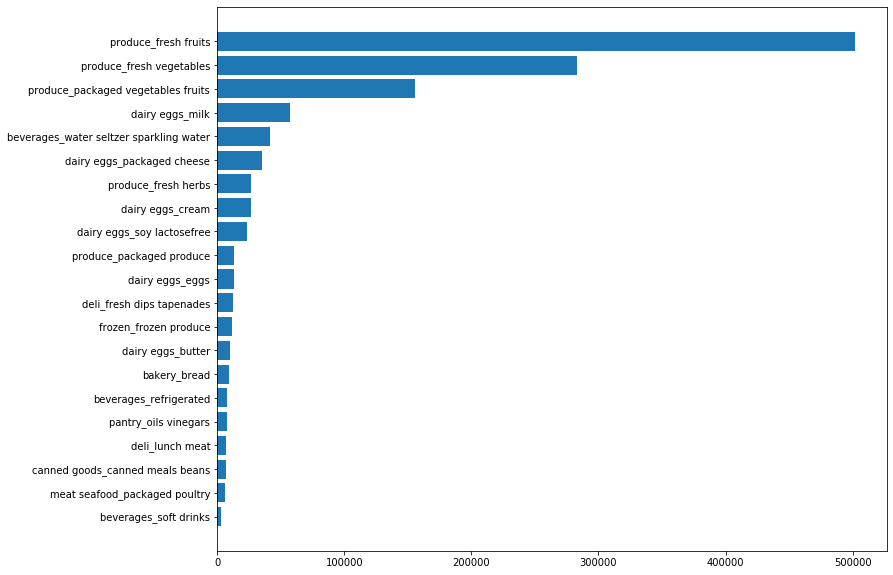

In [25]:
plt.figure(figsize = (12,10))
plt.barh([i[0] + '_' + i[1] for i in pivot_df1.index], pivot_df1['order_number'].values)
plt.show()

> 농산품이 압도적으로 많아보이는데, 상세 카테고리별 비중을 확인해볼 필요가 이씀

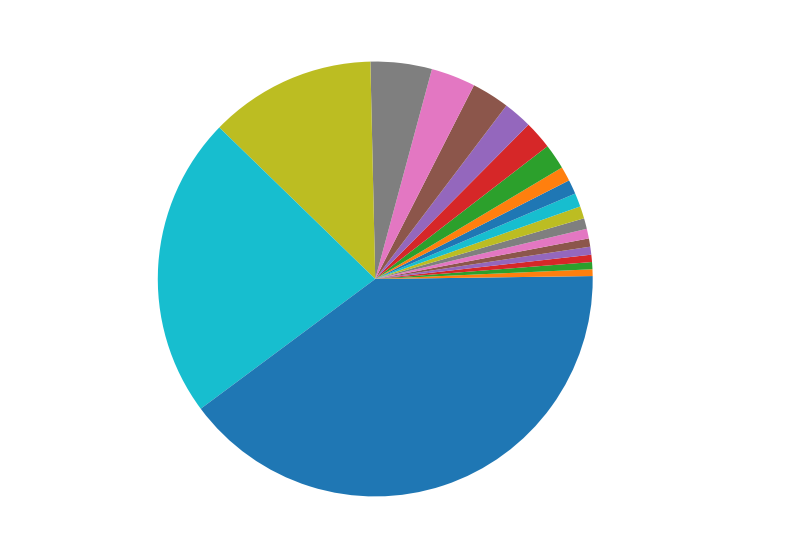

In [26]:
fig = plt.figure(figsize = (10,10))
plt.rcParams['text.color'] = 'white'
plt.pie(pivot_df1['order_number'].values, labels = [i[0] + '_' + i[1] for i in pivot_df1.index])
plt.show()

> 농산품이 판매량 기준에서도 가장 많음(전체 주문의 75%수준)  
naive 한 기준은 농산품위주가 될 것으로 예상  
input 이라면 묶어버렸겠지만 output 이므로 그냥 둠 

> 그럼 실제로 어떤 상품이 많이 팔리는지? 

In [27]:
pivot_df2 = pd.pivot_table(txp_df, index = ['name'], aggfunc = 'count', values = 'order_number').sort_values('order_number')

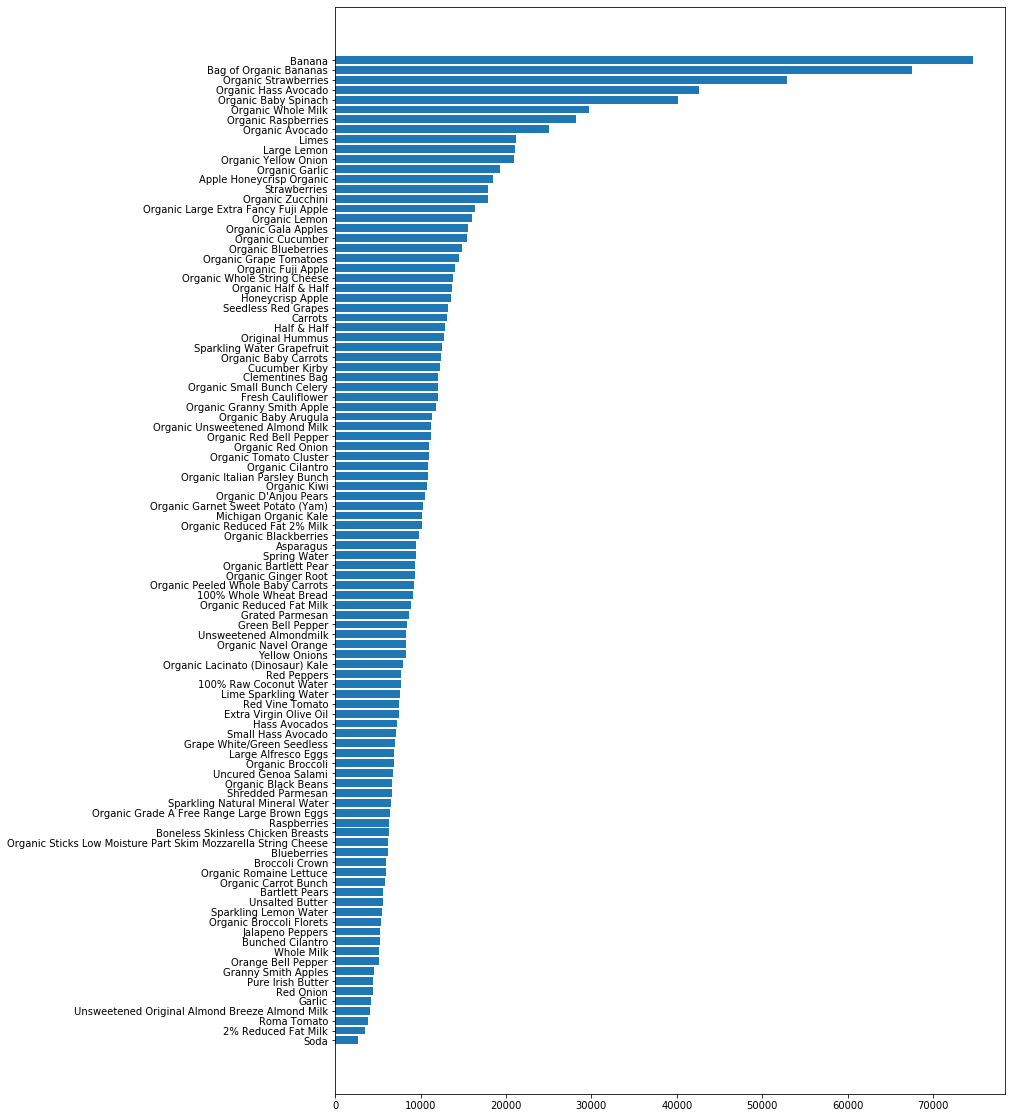

In [28]:
plt.figure(figsize = (12,20))
plt.barh(pivot_df2.index, pivot_df2['order_number'].values)
plt.show()

> 뭔데 바나나를 저렇게 주문함.. 원숭이가 

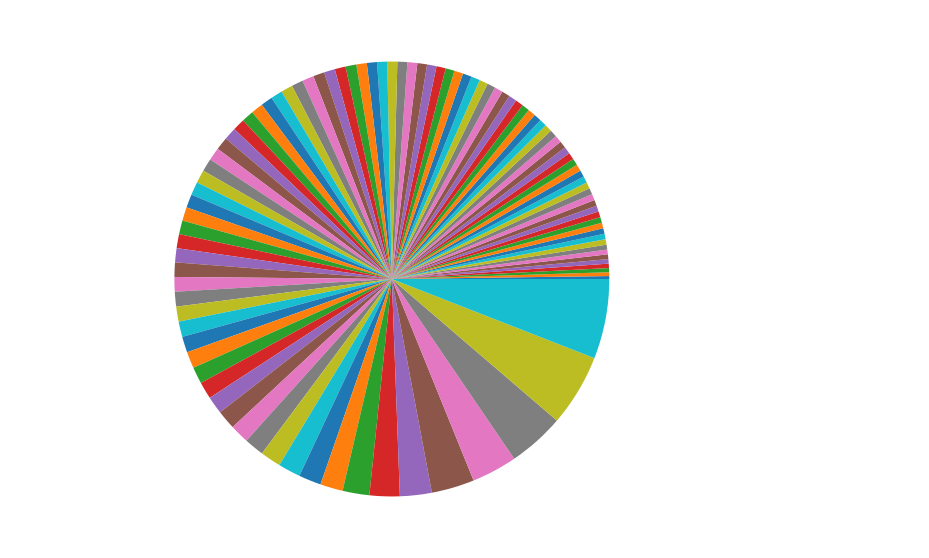

In [29]:
fig = plt.figure(figsize = (10,10))
plt.rcParams['text.color'] = 'white'
plt.pie(pivot_df2['order_number'].values, labels = pivot_df2.index)
plt.show()

> 이름은 이렇게 보기 안좋은 듯..  
카테고리별로 봐보자  

In [30]:
pivot_df3 = pd.pivot_table(txp_df, index = ['category_name','name'], aggfunc = 'count', values = 'order_number').sort_values('order_number')
pivot_df3.reset_index(inplace = True)

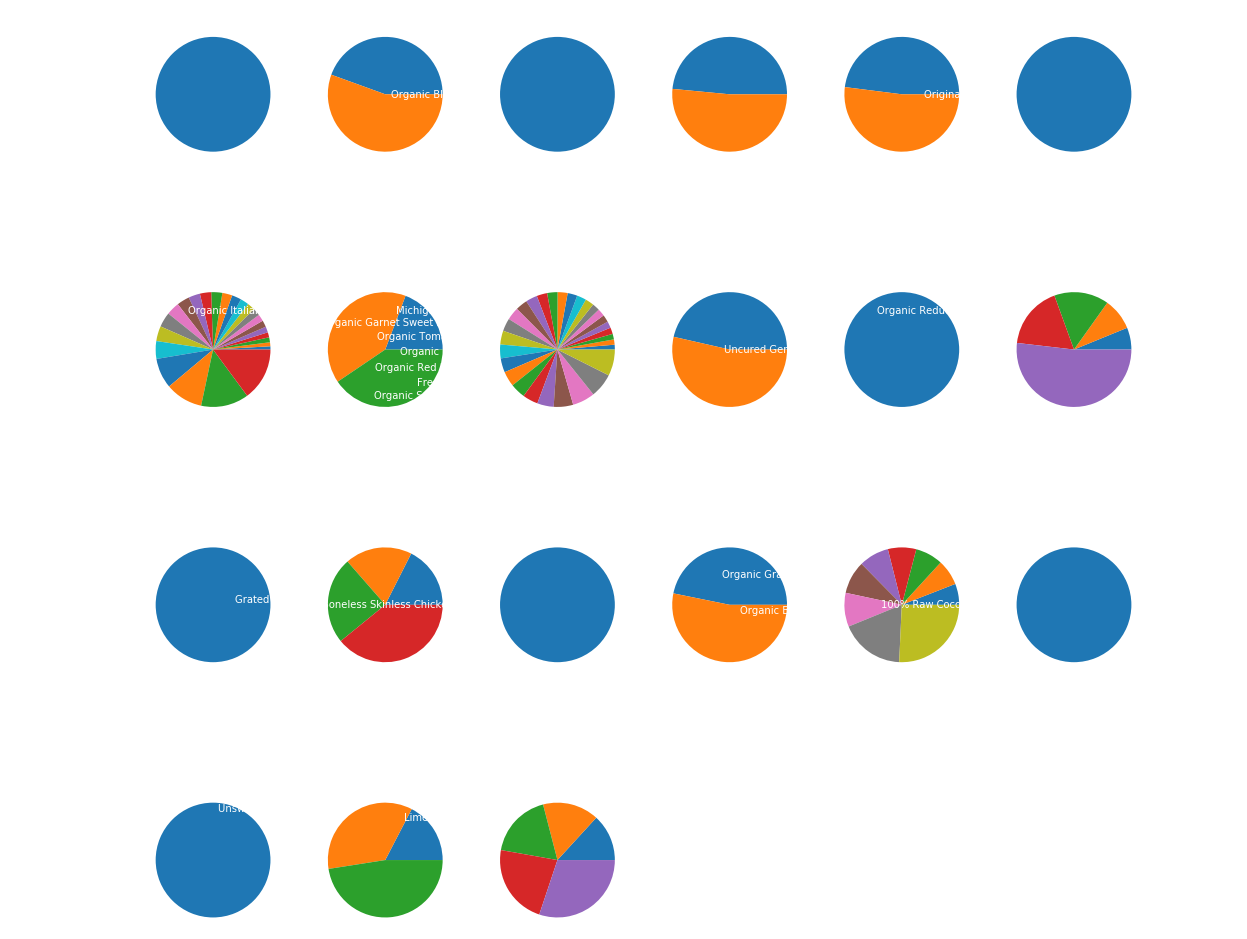

In [31]:
cat_lst = np.unique(pivot_df3['category_name'])
fig = plt.figure(figsize = (18,18))
plt.rcParams['text.color'] = 'white'
for i in range(len(cat_lst)):
    ax = fig.add_subplot(4,6,i+1)
    cat = cat_lst[i]
    tmp_pv = pivot_df3.loc[pivot_df3['category_name'] == cat]
    ax.title.set_text(cat)
    ax.pie(tmp_pv['order_number'].values, labels = tmp_pv['name'])
plt.show()    

> 카테고리단위로 세분화된 건 야채와 과일류네.. 이 부분은 좀 신경써서 봐야 겠다는 생각하고 다음 단계

### 3-3. 개별 주문의 특성은 어떠한가?  
> 개별 주문시 대량주문보다는 소량주문이 많으며(6개 품목 이하 주문이 전체의 80% 수준)  
다음 주문까지의 기간은 대부분 일주일 이내임. 아마 식료품이라는 소비재 특성상 재주문 빈도가 높은 것으로 보이고  
요일별 주문량은 일/월요일이 다른 요일에 비해 약 20% 정도 높으나 나머지 요일은 비슷한 수준을 보임  

In [34]:
txp_df.head()

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,div_kor,cat_kor,name,category_name,division_name
0,717029,196613,15,1,9,3.0,5,0,41220,농산품,신선야채,Organic Romaine Lettuce,fresh vegetables,produce
1,2325772,196613,35,6,11,2.0,7,1,41220,농산품,신선야채,Organic Romaine Lettuce,fresh vegetables,produce
2,71041,32780,26,6,14,1.0,1,0,41220,농산품,신선야채,Organic Romaine Lettuce,fresh vegetables,produce
3,1265600,65610,29,5,13,12.0,3,1,41220,농산품,신선야채,Organic Romaine Lettuce,fresh vegetables,produce
4,1338494,65610,37,3,19,3.0,2,1,41220,농산품,신선야채,Organic Romaine Lettuce,fresh vegetables,produce


In [35]:
txp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1260018 entries, 0 to 1260017
Data columns (total 14 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   order_id        1260018 non-null  object
 1   cstno           1260018 non-null  object
 2   order_number    1260018 non-null  object
 3   week_day        1260018 non-null  object
 4   order_hour      1260018 non-null  object
 5   order_interval  1260018 non-null  object
 6   add_order       1260018 non-null  object
 7   is_reordered    1260018 non-null  object
 8   product_id      1260018 non-null  object
 9   div_kor         1260018 non-null  object
 10  cat_kor         1260018 non-null  object
 11  name            1260018 non-null  object
 12  category_name   1260018 non-null  object
 13  division_name   1260018 non-null  object
dtypes: object(14)
memory usage: 144.2+ MB


> null 은 없는데, 좀 편한 정렬 및 작업을 위해 숫자형으로 변환

In [36]:
num_features = ['order_id','order_number', 'order_interval','add_order']
for num_feature in num_features:
    try:
        txp_df[num_feature] = txp_df[num_feature].astype('float').astype('int')
    # 숫자가 아닌게 있는 경우 
    except:
        print(num_feature)
        continue

order_interval


> 숫자가 아닌 데이터 존재

In [37]:
np.unique(txp_df['order_interval'])

array(['', '0.0', '1.0', '10.0', '11.0', '12.0', '13.0', '14.0', '15.0',
       '16.0', '17.0', '18.0', '19.0', '2.0', '20.0', '21.0', '22.0',
       '23.0', '24.0', '25.0', '26.0', '27.0', '28.0', '29.0', '3.0',
       '30.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0'], dtype=object)

> 이런 애들은 왜 그런걸까?

In [38]:
txp_df[txp_df['order_interval'] == '']['order_number'].max()

1

> 비어 있는 대상들은 해당일자에 최초 주문건들이네

In [39]:
np.unique(txp_df[txp_df['order_number'] == 1]['order_interval'])

array([''], dtype=object)

> 반대도 맞음. 일자별 최초 유입건은 인터벌이 안들어온다. 나중에 처리 필요, 일단 -1로 집어넣어두고 계속 진행

In [40]:
txp_df['order_interval'] = txp_df['order_interval'].apply(lambda x : -1 if x == '' else int(float(x)))

In [41]:
np.unique(txp_df['order_interval'])

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [42]:
txp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1260018 entries, 0 to 1260017
Data columns (total 14 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   order_id        1260018 non-null  int64 
 1   cstno           1260018 non-null  object
 2   order_number    1260018 non-null  int64 
 3   week_day        1260018 non-null  object
 4   order_hour      1260018 non-null  object
 5   order_interval  1260018 non-null  int64 
 6   add_order       1260018 non-null  int64 
 7   is_reordered    1260018 non-null  object
 8   product_id      1260018 non-null  object
 9   div_kor         1260018 non-null  object
 10  cat_kor         1260018 non-null  object
 11  name            1260018 non-null  object
 12  category_name   1260018 non-null  object
 13  division_name   1260018 non-null  object
dtypes: int64(4), object(10)
memory usage: 144.2+ MB


> 처리 됐으니.. 이제 모니터링 시작  

> 내역 -> 주문단위 -> 고객단위 순서로 훑어 올라갈 예정.  
내역은 봤으니 주문 기준에서 한번 체크 

> 각 주문의 특성 및 패턴은?

In [43]:
order_pivot_df = pd.pivot_table(txp_df, index = ['order_id','week_day','order_interval','cstno'], values = 'name', aggfunc = 'count')

In [44]:
order_df = order_pivot_df.reset_index()

In [45]:
order_df.rename(columns = {'name':'product_cnt'}, inplace = True)

In [46]:
order_df

,order_id,week_day,order_interval,cstno,product_cnt
0,5,6,9,156122,4
1,14,3,3,18194,3
2,28,3,6,98256,3
3,50,1,4,94330,1
4,56,0,2,41591,6
...,...,...,...,...,...
341673,3421003,0,14,86905,2
341674,3421012,4,4,179069,6
341675,3421027,2,2,51127,3
341676,3421041,6,2,179516,3


> 34만건의 주문이 있었고

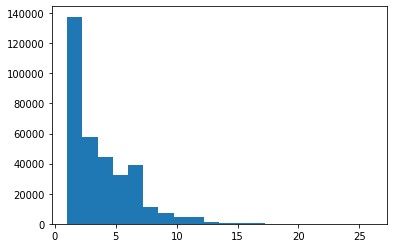

In [47]:
plt.hist(order_df['product_cnt'], bins = 20)
plt.show()

> 대부분의 주문이 5~6개 이하의 품목을 주문하였음  

/opt/conda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  after removing the cwd from sys.path.


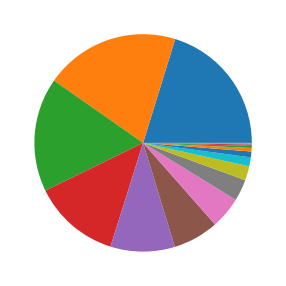

In [48]:
fig = plt.figure(figsize = (5,5))
plt.rcParams['text.color'] = 'white'
tmp_df = pd.pivot_table(order_df, index = 'product_cnt', aggfunc = 'count', values = 'order_id')
plt.pie(tmp_df, labels = tmp_df.index)
plt.show()

In [49]:
order_df['product_cnt'].describe()

count    341678.000000
mean          3.687735
std           2.563467
min           1.000000
25%           2.000000
50%           3.000000
75%           5.000000
max          26.000000
Name: product_cnt, dtype: float64

> 80% 이상의 주문이 6가지 품목 이하를 함께 구매했음

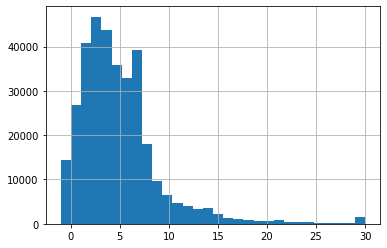

In [50]:
order_df['order_interval'].hist(bins = 30)

> 개별 주문의 간격은 꽤 짧은 편으로 보임. 

In [51]:
order_df['order_interval'].describe()

count    341678.000000
mean          5.225780
std           4.140268
min          -1.000000
25%           3.000000
50%           4.000000
75%           7.000000
max          30.000000
Name: order_interval, dtype: float64

> 이전 주문 후 대부분의 추가 주문이 일주일 내에 발생함.  
신선식품을 주로 취급하는 곳이라 그럴 것으로 추정됨

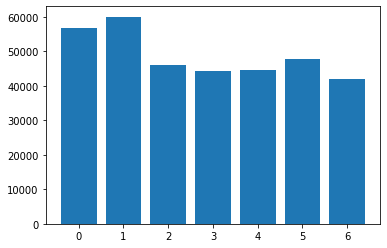

In [52]:
tmp_df = pd.pivot_table(order_df, index = 'week_day', values = 'order_id', aggfunc = 'count')
plt.bar(x = tmp_df.index, height = tmp_df['order_id'].values)
plt.show()

> 주문이 가장 많은 요일은 월요일, 이게 좀 신기함.  
주말에 다음주 먹을 재료들을 사두고 준비할 것 같았는데, 그래도 다른 요일도 주문량이 적지는 않음  

### 3-4. 고객의 주문 특성은 어떠한가?  
> 모든 고객이 최소 40번이상 주문을 했음. retension 이 굉장히 높다고 판단되고,  
유사한 고객, 유사한 물품등에 기반한 예측보다는 개인의 주문 패턴에 기반해서 추정하는 방식이 가장 적절할 것으로 보임

In [53]:
cst_order_df = pd.pivot_table(order_df, index = 'cstno', values = 'order_id', aggfunc = 'count')

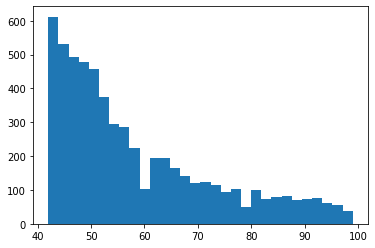

In [54]:
plt.hist(cst_order_df['order_id'], bins = 30)
plt.show()

> 한 번만 주문한 고객은 없네? 

In [55]:
cst_order_df.describe()

,order_id
count,5859.000000
mean,58.316778
std,14.640439
min,42.000000
25%,47.000000
50%,53.000000
75%,66.000000
max,99.000000


> 보통 60번씩 주문하고 최소 40번 이상 주문을 했다면 엄청나네..  
데이터의 기간이 궁금해짐. 나중에 만들어 봐야겠음

### 3-5. 품목별 주문 특성은?  
> 대부분의 주문이 재구매에 의해 이루어짐, 개인별 품목별 구매주기 등이 더 중요할 것으로 보임  
품목별 재구매빈도는 이전주문과의 interval 만 남아있어서 만들어 봐야 할 듯 

### 3-6. 날짜로 한번 바꿔서 테스트
> 고객별 order_number 를 사용해서 날짜를 추정하고 고객/품목 별 거래빈도를 계산  
1) order_number로 살펴보면 모든 구매 이력이 다 있고, 가장 마지막 시점 구매를 기점으로 역산해서 며칠의 gap이 있는지 보자

In [110]:
txp_df = get_df("select * from train_x_past", schema)

In [111]:
txp_df['order_interval'] = txp_df['order_interval'].apply(lambda x : 0 if x == '' else int(float(x)))
txp_df['order_interval'] = txp_df['order_interval'].astype('float').astype('int')

In [112]:
cum_order = pd.pivot_table(txp_df, index = ['cstno','order_number'], values = 'order_interval', aggfunc = 'max')
cum_order['cum_order_interval'] = cum_order.groupby(['cstno'])['order_interval'].cumsum()

In [113]:
txp_df = pd.merge(txp_df, cum_order['cum_order_interval'], left_on = ['cstno', 'order_number'], right_on = ['cstno', 'order_number'])

In [114]:
txp_df.sort_values(by = ['cstno','product_id','order_number'], inplace = True)

In [115]:
txp_df['shift_cum'] = txp_df.groupby(['cstno','product_id'])['cum_order_interval'].shift()
txp_df['item_interval'] = txp_df['cum_order_interval'] - txp_df['shift_cum'].fillna(-1) # 어차피 재주문여부 따라 볼거니깐 우선 0으로 채우고 

> cstno , order number, order interval 로 상품별 구매간격 계산 가능

### 3-7. 주로 처음에 뭘 사러 들어온걸까? 
> 주문내역들이 데이터가 비어 있어도 갯수가 충분하기 때문에 처음에 사려고 유입된 품목이 무엇인지는 확인이 가능할 것으로 판단  
최초 픽 하는 물품은 역시 바나나가 제일 많았음  

In [57]:
txp_df['is_reordered'] = txp_df['is_reordered'].astype('int')
tmp_df = pd.pivot_table(txp_df, index = 'name', values = 'is_reordered', aggfunc = 'mean').sort_values(by = 'is_reordered')
h_tmp_df = tmp_df.head(20)
l_tmp_df = tmp_df.tail(20)

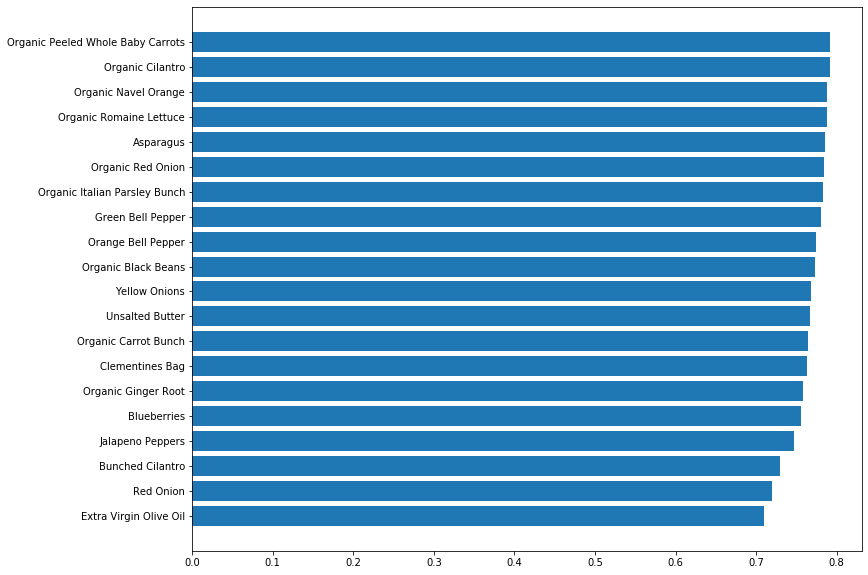

In [58]:
plt.figure(figsize = (12,10))
plt.barh(h_tmp_df.index, h_tmp_df['is_reordered'])
plt.show()

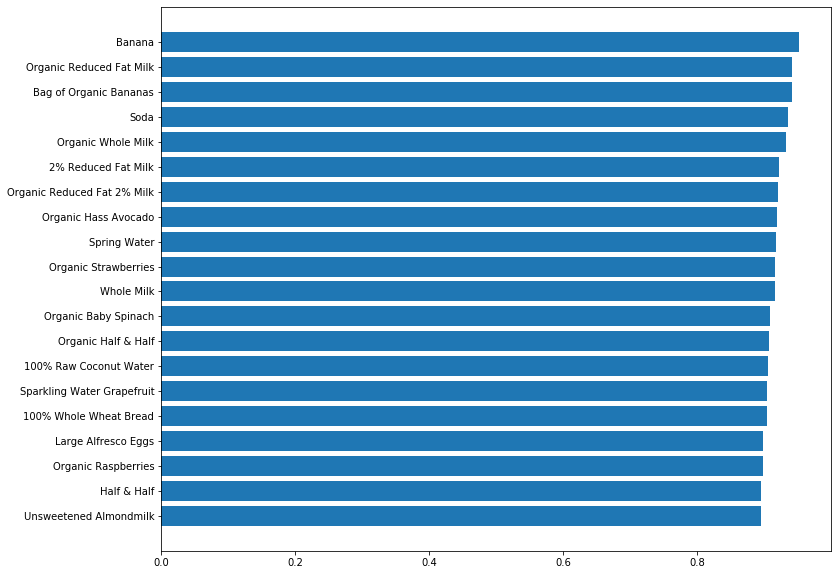

In [59]:
plt.figure(figsize = (12,10))
plt.barh(l_tmp_df.index, l_tmp_df['is_reordered'])
plt.show()

> 최소 70%이상의 주문이 재구매에 의해 이루어짐.  
개인별 히스토리를 잘 관리하면 다음 구매 패턴이 추정될 것으로 보임. 비슷한 사람이 뭐 샀는지 이런건 안봐도 될듯

In [60]:
tmp_df = pd.pivot_table(txp_df, index = 'name', values = 'order_interval', aggfunc = 'mean').sort_values(by = 'order_interval')

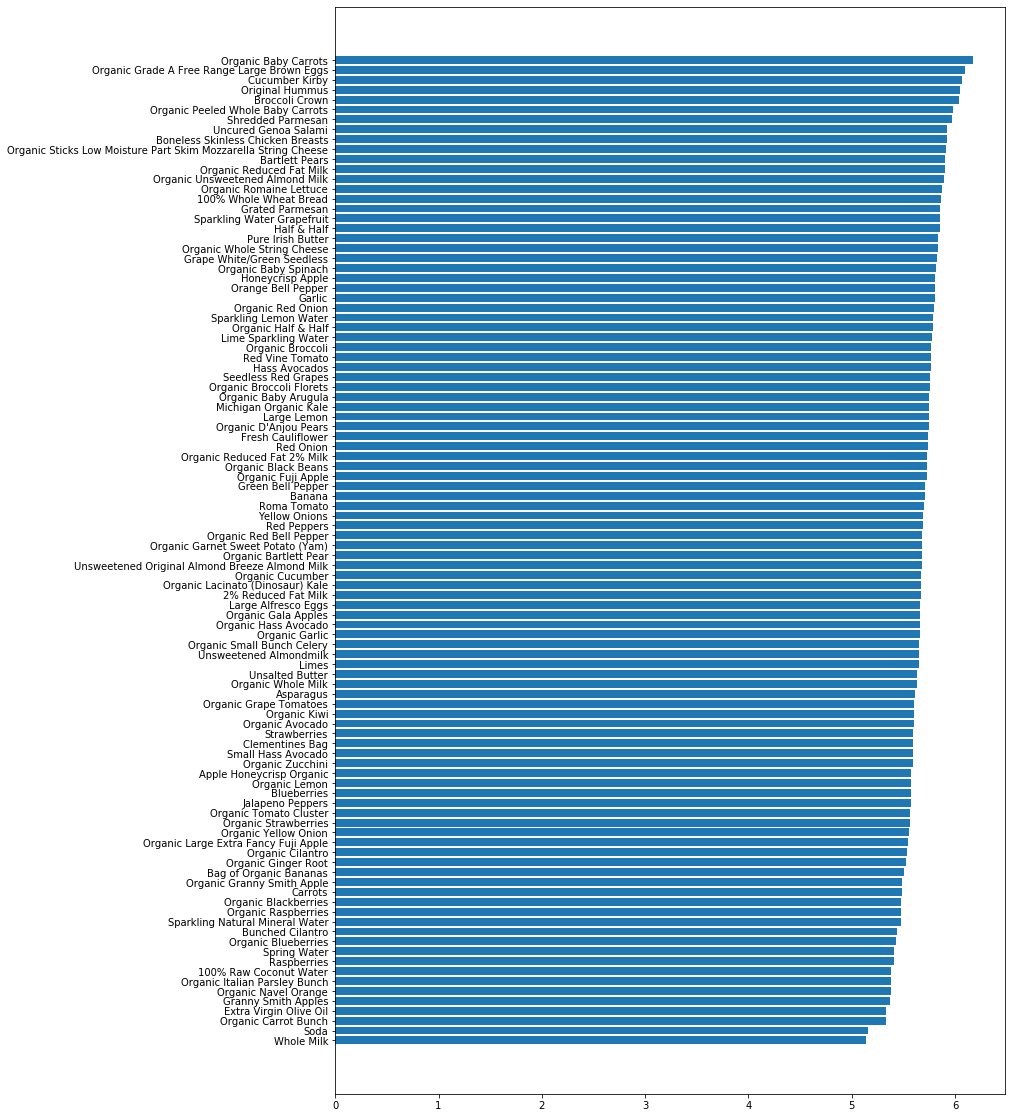

In [61]:
plt.figure(figsize = (12,20))
plt.barh(tmp_df.index, tmp_df['order_interval'])
plt.show()

> 품목별 구매빈도를 보고 싶었으나, 이건 주문기준이라서 확인이 어려울 듯  
좀 더 가공해서 보자 

In [61]:
tmp_df = pd.pivot_table(txp_df[txp_df['add_order'] == 1], index = 'name', aggfunc = 'count', values = 'order_id').sort_values(by = 'order_id')

In [62]:
tmp_df['total'] = tmp_df['order_id'].sum()

In [63]:
tmp_df['rt'] = tmp_df['order_id'] / tmp_df['total']

In [64]:
tmp_df

,order_id,total,rt
name,,,
Roma Tomato,239,133657,0.001788
Orange Bell Pepper,266,133657,0.001990
Garlic,266,133657,0.001990
Red Onion,267,133657,0.001998
Jalapeno Peppers,297,133657,0.002222
...,...,...,...
Organic Hass Avocado,4350,133657,0.032546
Organic Strawberries,5083,133657,0.038030
Organic Whole Milk,6258,133657,0.046821


> 최초 구입품목은 역시 바나나.. 이정도면 모두 바나나 사러 들어왔다고 해도 어느 정도 숫자가 나올것 같다

### 3-8. 주문의 특징을 판단할 수 있을까?   
> 개별 항목간의 관계는? 주문유형별 분류가 가능한지?  
특정 항목(바나나-포장바나나 등)은 함께 사지 않는등 상식적인 선에서 몇 가지 결과가 확인됨  
주문유형별로는 개별 항목의 주문 설명력이 pca후에도 낮아(최대 5%수준) 주문유형을 특정하기보다 고객의 주문내역을 특정화 하는게 나을 것 같음.  
고객의 주문품목을 특정화 후 주문행동패턴(요일, 빈도) 를 판단해야겠다  


In [66]:
le = LabelEncoder()
ohe = OneHotEncoder(sparse=False)
ohe_df = pd.DataFrame(ohe.fit_transform(le.fit_transform(txp_df['name']).reshape(-1,1)), columns = le.classes_)

In [67]:
corr_df = pd.concat([txp_df, ohe_df], axis = 1)
corr_df = pd.pivot_table(corr_df, index = 'order_id', values = corr_df.columns[14:], aggfunc = 'max')

> 34만건 주문의 거래 부분내역(전체는 아니니.. 이거 참 별로네) 으로 한번 품목간 관계를 확인 

In [68]:
corr_df = corr_df.corr()

In [69]:
np.fill_diagonal(corr_df.values, 0)

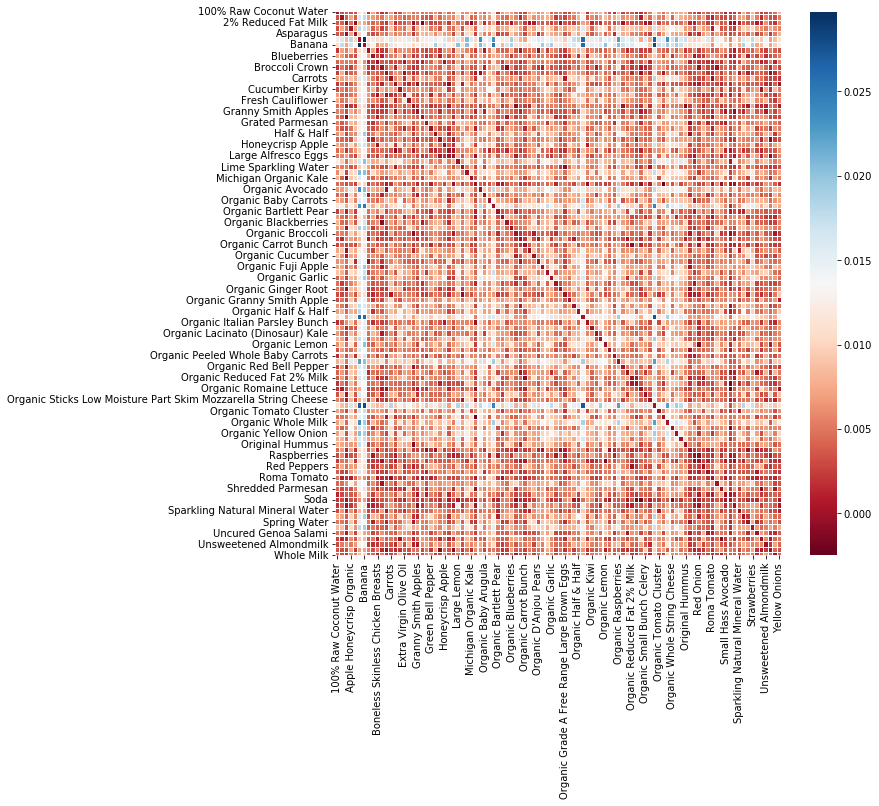

In [70]:
plt.figure(figsize = (10,10))
sns.heatmap(corr_df, cmap = 'RdBu', linewidths = 0.1)

> 품목이 너무 많아 어차피 잘 안보인다.  
항목별로 주문에 같이 많이 들어가는 경우와 아닌 경우를 좀 만들어 봐야겠다  
특정 상품은 당연하게 같이 구매 안할거고(바나나 , 포장바나나) 특정 상품은 같이 구매하는 특성이 나올 수 있을 듯  

> 주문특성을 한번 만들어 보자 

In [72]:
pca = PCA()

> 주문별 특성이 있다면 어느 정도 해당 주문이 어떤 유형인지 판단이 가능할 것, 그리고 어떤 주문을 하는 고객이냐가 판별되지 않을까?

In [74]:
ohe_df

,100% Raw Coconut Water,100% Whole Wheat Bread,2% Reduced Fat Milk,Apple Honeycrisp Organic,Asparagus,Bag of Organic Bananas,Banana,Bartlett Pears,Blueberries,Boneless Skinless Chicken Breasts,...,Sparkling Natural Mineral Water,Sparkling Water Grapefruit,Spring Water,Strawberries,Uncured Genoa Salami,Unsalted Butter,Unsweetened Almondmilk,Unsweetened Original Almond Breeze Almond Milk,Whole Milk,Yellow Onions
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1253968,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1253969,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1253970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
pca_df = pca.fit_transform(ohe_df)

In [77]:
pca_df = pd.DataFrame(pca_df)

<BarContainer object of 100 artists>

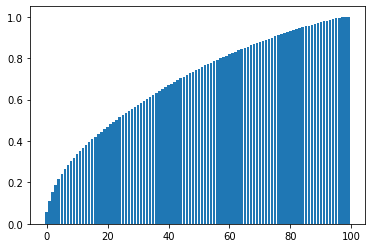

In [81]:
plt.bar(range(100),pca.explained_variance_ratio_.cumsum())

In [85]:
pca.explained_variance_ratio_.cumsum()

array([0.05896098, 0.11114641, 0.15260798, 0.18654401, 0.21778497,
       0.24163028, 0.26406244, 0.2840801 , 0.30126782, 0.31832512,
       0.33493517, 0.3504948 , 0.36541953, 0.37995628, 0.3941522 ,
       0.40738527, 0.42028198, 0.43291662, 0.4453254 , 0.45731061,
       0.46897256, 0.48029921, 0.49148645, 0.50252646, 0.51341479,
       0.52410636, 0.53468189, 0.54509736, 0.55539389, 0.5655397 ,
       0.57557831, 0.58548049, 0.59526918, 0.60492148, 0.61436744,
       0.6235483 , 0.63269228, 0.64173969, 0.6506688 , 0.65956349,
       0.66839635, 0.67717521, 0.68580259, 0.69423905, 0.70254382,
       0.71078379, 0.71882578, 0.72667618, 0.7343571 , 0.74198711,
       0.74956041, 0.75708337, 0.76449514, 0.77173093, 0.77881313,
       0.78573284, 0.79252089, 0.79926857, 0.80599105, 0.81253239,
       0.81891959, 0.8252097 , 0.83140452, 0.83750944, 0.84356224,
       0.84948536, 0.85531539, 0.86105266, 0.86671663, 0.87232465,
       0.87787433, 0.88334919, 0.8887806 , 0.89415156, 0.89939

> 120만개 주문 중 3가지 유형정도에서 약 15% 설명이 되고 9가지 유형에서 30% 가량 설명이 된다.  
가장 큰 특징은?

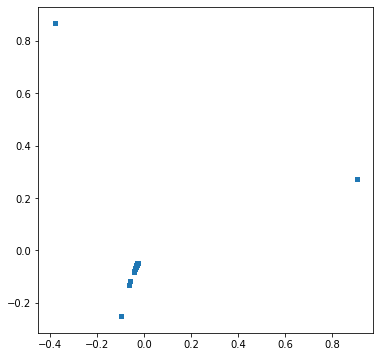

In [92]:
plt.figure(figsize = (6,6))
plt.scatter(pca_df.iloc[:,0], pca_df.iloc[:,1], alpha = 0.1, s = 15)
plt.show()

> 약 5가지 정도의 주문유형으로 나눠질 것같음.  
이거로 좀이따가 군집화 시켜서 다시 한번 사이즈까지 체크 

In [103]:
pc1_df = pd.DataFrame(pca.components_[0].T, index = ohe_df.columns, columns = ['PC1'])
pc2_df = pd.DataFrame(pca.components_[1].T, index = ohe_df.columns, columns = ['PC2'])

In [106]:
pc1_df.sort_values(by = 'PC1', ascending = False)

,PC1
Banana,0.930437
Soda,-0.001023
2% Reduced Fat Milk,-0.001355
Roma Tomato,-0.001468
Unsweetened Original Almond Breeze Almond Milk,-0.001587
...,...
Organic Whole Milk,-0.018320
Organic Baby Spinach,-0.032574
Organic Hass Avocado,-0.037475
Organic Strawberries,-0.070971


> 바나나를 사고, 포장바나나를 안산 주문이 가장 중요한 요소로 판단됨. 우측 하나의 포인트는 바나나를 산 사람들, 좌측 점은 포장바나나  
가운데는 나머지 80% 넘는 정보 비중

In [107]:
pc2_df.sort_values(by = 'PC2', ascending = False)

,PC2
Bag of Organic Bananas,0.912084
Banana,0.316848
Soda,-0.001955
2% Reduced Fat Milk,-0.002593
Roma Tomato,-0.002812
...,...
Organic Raspberries,-0.034731
Organic Whole Milk,-0.038287
Organic Baby Spinach,-0.073768
Organic Hass Avocado,-0.087379


> 이게 좀 더 재밌는 결과 같은데..  
바나나를 사고, 포장바나나를 안사는 주문 특성이 pc1로 선정되고, 포장바나나를 주문하는게 중요한 포인트가 됨  
근데 또 바나나가 다음 설명변수로 포함이 됨.  
pc1 에서 설명되고 남은 설명력으로도 바나나면.. 뭐 일단 좀 더 봐야할듯

> 2차원으로 눈으로 봤을때는 주문유형이 바나나로 분류되는데 실제 군집화를 몇 개 시켜보고 해당 주문 유형을 정의해보자 

In [119]:
dist = []
for i in range(1,10):
    st = time.time()
    kmeans = KMeans(i, init = 'k-means++', random_state = 0)
    kmeans.fit(pca_df)
    dist.append(kmeans.inertia_)
    sec = round(time.time() - st,2)
    print(f'{i}th Process...({sec}sec)', flush=True)

1th Process...(8.6sec)
2th Process...(16.05sec)
3th Process...(21.09sec)
4th Process...(23.24sec)
5th Process...(26.18sec)
6th Process...(30.34sec)
7th Process...(35.15sec)
8th Process...(41.88sec)
9th Process...(47.55sec)


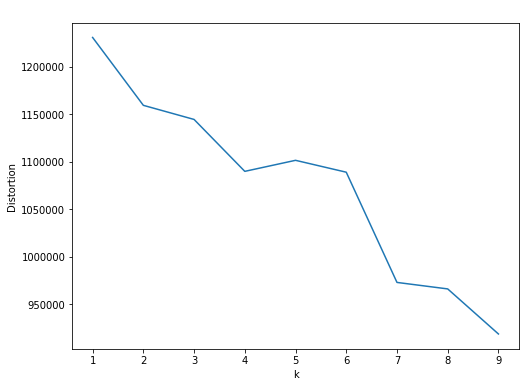

In [120]:
plt.figure(figsize = (8,6))
plt.plot(range(1,10), dist)
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow for optimal K')
plt.show()

> 차원이 너무 크다...  9가지 pc값들정도로만 파악해보자 

In [ ]:
sub_pca_df = pca_df.iloc[:,:10]

In [125]:
dist = []
for i in range(1,10):
    st = time.time()
    kmeans = KMeans(i, init = 'k-means++', random_state = 0)
    kmeans.fit(sub_pca_df)
    dist.append(kmeans.inertia_)
    sec = round(time.time() - st,2)
    print(f'{i}th Process...({sec}sec)', flush=True)

1th Process...(1.47sec)
2th Process...(3.14sec)
3th Process...(4.53sec)
4th Process...(5.34sec)
5th Process...(5.65sec)
6th Process...(6.09sec)
7th Process...(7.58sec)
8th Process...(10.07sec)
9th Process...(11.16sec)


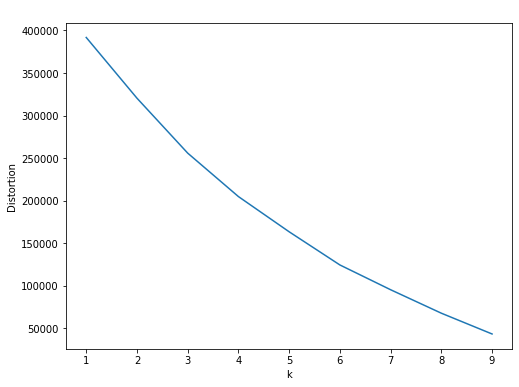

In [126]:
plt.figure(figsize = (8,6))
plt.plot(range(1,10), dist)
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow for optimal K')
plt.show()

> 계속 감소.. 그럼 일단 9가지 정도 패턴으로 다시 도식화 시켜보면 

In [129]:
pca_df['seg'] = kmeans.predict(sub_pca_df)

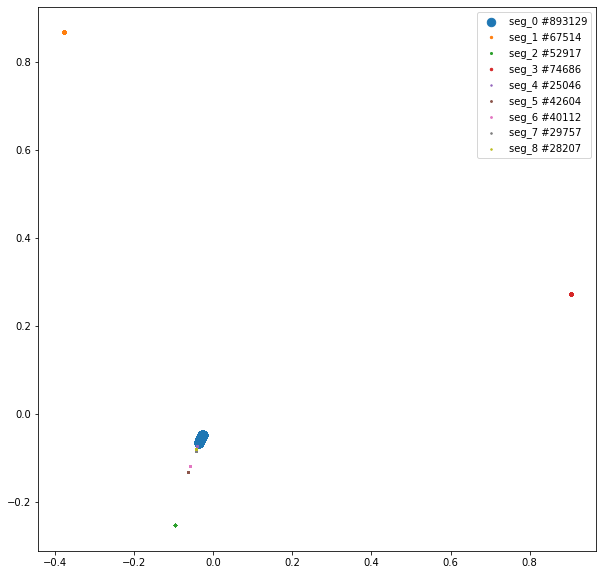

In [137]:
plt.figure(figsize = (5,5))
plt.rcParams['text.color'] = 'black'
tot_size = len(pca_df)
for i in range(9):
    seg_pca_df = pca_df.loc[pca_df['seg'] == i]
    seg_size = len(seg_pca_df)
    plt.scatter(seg_pca_df.iloc[:,0], seg_pca_df.iloc[:,1], label = 'seg_{} #{}'.format(i, seg_size), s = seg_size/tot_size * 100)
plt.legend()
plt.show()        

> 일단 빨강, 주황, 특징을 다시 보자 

In [141]:
# 빨간색 seg3 
pca_df.loc[pca_df['seg'] == 3].describe()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,seg
count,7.468600e+04,7.468600e+04,7.468600e+04,7.468600e+04,7.468600e+04,7.468600e+04,7.468600e+04,7.468600e+04,7.468600e+04,7.468600e+04,...,7.468600e+04,7.468600e+04,7.468600e+04,7.468600e+04,7.468600e+04,7.468600e+04,7.468600e+04,7.468600e+04,7.468600e+04,74686.0
mean,9.040789e-01,2.724927e-01,7.332450e-02,2.225497e-02,3.865887e-02,8.315617e-03,1.144320e-02,7.708312e-03,9.983209e-04,-2.300806e-04,...,-4.126701e-04,-3.362770e-04,-1.558429e-04,-2.847028e-04,-2.109071e-04,-2.590934e-04,-2.483602e-04,-2.435395e-04,1.221801e-16,3.0
std,2.326442e-14,5.620023e-14,8.349518e-14,7.264707e-14,5.324816e-14,3.900380e-14,7.776959e-14,2.387540e-14,1.801095e-14,3.663178e-14,...,1.610250e-14,5.044980e-15,2.598897e-15,1.368531e-14,7.829327e-15,1.045208e-14,1.440276e-14,8.814696e-15,1.775665e-13,0.0
min,9.040789e-01,2.724927e-01,7.332450e-02,2.225497e-02,3.865887e-02,8.315617e-03,1.144320e-02,7.708312e-03,9.983209e-04,-2.300806e-04,...,-4.126701e-04,-3.362770e-04,-1.558429e-04,-2.847028e-04,-2.109071e-04,-2.590934e-04,-2.483602e-04,-2.435395e-04,-3.736766e-13,3.0
25%,9.040789e-01,2.724927e-01,7.332450e-02,2.225497e-02,3.865887e-02,8.315617e-03,1.144320e-02,7.708312e-03,9.983209e-04,-2.300806e-04,...,-4.126701e-04,-3.362770e-04,-1.558429e-04,-2.847028e-04,-2.109071e-04,-2.590934e-04,-2.483602e-04,-2.435395e-04,-1.160295e-15,3.0
50%,9.040789e-01,2.724927e-01,7.332450e-02,2.225497e-02,3.865887e-02,8.315617e-03,1.144320e-02,7.708312e-03,9.983209e-04,-2.300806e-04,...,-4.126701e-04,-3.362770e-04,-1.558429e-04,-2.847028e-04,-2.109071e-04,-2.590934e-04,-2.483602e-04,-2.435395e-04,-1.160295e-15,3.0
75%,9.040789e-01,2.724927e-01,7.332450e-02,2.225497e-02,3.865887e-02,8.315617e-03,1.144320e-02,7.708312e-03,9.983209e-04,-2.300806e-04,...,-4.126701e-04,-3.362770e-04,-1.558429e-04,-2.847028e-04,-2.109071e-04,-2.590934e-04,-2.483602e-04,-2.435395e-04,-1.160295e-15,3.0
max,9.040789e-01,2.724927e-01,7.332450e-02,2.225497e-02,3.865887e-02,8.315617e-03,1.144320e-02,7.708312e-03,9.983209e-04,-2.300806e-04,...,-4.126701e-04,-3.362770e-04,-1.558429e-04,-2.847028e-04,-2.109071e-04,-2.590934e-04,-2.483602e-04,-2.435395e-04,3.688020e-11,3.0


> 빨간색은 pc1 이 큰 집단이므로 바나나를 사고, 포장바나나를 안사는 주문유형
주황색은 pc2가 큰 집단이므로 포장바나나를 사는 주문유형.    
잘 안보일거 같긴한데.. 고객유형으로 바꿔서 가보면 좀 더 보이지 않을까 생각중?

### 3-9. 구매 항목에 따라 고객군을 좀 나눠본다면??
> 구매내역에 따르면 약 5가지 고객군으로 판단됨.  
이용량이 많은지 적은지, 바나나를 선호하는지 포장바나나를 선호하는지..로 크게 보면 4가지로도 나눠질 수 있을듯.  
- 4번 세그먼트(보라) : 바나나를 사러 들어오는게 주 목표인 고객, 바나나 외 다른걸 사는 빈도는 그냥 저냥..  포장바나나는 구매하지 않음. 
- 3번 세그먼트(빨강) : 바나나나 포장바나나가 주가 아닌 고객, 아보카도를 선호함.  기타 과일이나 포장바나나도 가끔 구매. 바나나는 구매하지 않음. 
- 2번 세그먼트(초록) : 4번과 굉장히 유사하지만 바나나가 포장바나나로 대체된 고객군  
- 1번 세그먼트(노랑) : 바나나에 별로 관심이 없는 고객. 구매량도 적고 우유를 가장 많이 구매함  
- 0번 세그먼트(파랑) : 1번 세그먼트와 비슷하지만 1번 세그먼트가 포장바나나를 구매했다면 0번 세그먼트는 바나나를 선호하는 편. 

>

> index 가 바껴있으니.. 재정비 하고 ohe와 txp를 병합  

In [147]:
txp_df.reset_index(drop = True, inplace = True)

In [153]:
cst_base_df = pd.concat([txp_df, ohe_df], 1)

> 계산가능하게.. 

> 고객의 주문패턴과, 구매내역패턴을 별도로 진행

In [168]:
cst_order_df = pd.pivot_table(cst_base_df, index = ['cstno','order_id'], values = cst_base_df.columns[14:], aggfunc = 'sum')

>

In [170]:
cst_order_df.reset_index()

,cstno,order_id,100% Raw Coconut Water,100% Whole Wheat Bread,2% Reduced Fat Milk,Apple Honeycrisp Organic,Asparagus,Bag of Organic Bananas,Banana,Bartlett Pears,...,Sparkling Natural Mineral Water,Sparkling Water Grapefruit,Spring Water,Strawberries,Uncured Genoa Salami,Unsalted Butter,Unsweetened Almondmilk,Unsweetened Original Almond Breeze Almond Milk,Whole Milk,Yellow Onions
0,10000,12156,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10000,103998,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10000,192826,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10000,193643,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10000,236049,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341673,99901,3264185,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
341674,99901,3270614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
341675,99901,3293557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
341676,99901,3369192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [172]:
cst_item_df = pd.pivot_table(cst_order_df, index = 'cstno', aggfunc = 'sum')

In [173]:
cst_item_df

,100% Raw Coconut Water,100% Whole Wheat Bread,2% Reduced Fat Milk,Apple Honeycrisp Organic,Asparagus,Bag of Organic Bananas,Banana,Bartlett Pears,Blueberries,Boneless Skinless Chicken Breasts,...,Sparkling Natural Mineral Water,Sparkling Water Grapefruit,Spring Water,Strawberries,Uncured Genoa Salami,Unsalted Butter,Unsweetened Almondmilk,Unsweetened Original Almond Breeze Almond Milk,Whole Milk,Yellow Onions
cstno,,,,,,,,,,,,,,,,,,,,,
10000,0.0,41.0,0.0,0.0,0.0,6.0,30.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0
100001,20.0,0.0,0.0,4.0,0.0,41.0,0.0,0.0,3.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
100046,0.0,0.0,0.0,0.0,1.0,2.0,21.0,3.0,0.0,0.0,...,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
100071,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
100108,0.0,0.0,0.0,14.0,0.0,20.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9981,0.0,0.0,15.0,0.0,0.0,0.0,45.0,0.0,0.0,0.0,...,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99829,0.0,1.0,0.0,0.0,0.0,1.0,34.0,0.0,8.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,16.0,0.0,12.0
99887,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


> 고객별 누계 상품구매이력을 벡터로 잡고, 이거 갖고 다시 고객 구매패턴을 군집화 시켜보자 

In [174]:
pca = PCA()

In [182]:
cst_pca_df = pca.fit_transform(cst_item_df)

In [183]:
pca.explained_variance_ratio_.cumsum()

array([0.12463788, 0.19917331, 0.23976777, 0.28019989, 0.31407791,
       0.34161419, 0.3644324 , 0.38553086, 0.40495299, 0.42300292,
       0.43994829, 0.45628478, 0.47201596, 0.48752491, 0.50260326,
       0.51696342, 0.53104028, 0.54401509, 0.5568924 , 0.56947896,
       0.58141844, 0.59310228, 0.60441939, 0.61540112, 0.6261444 ,
       0.63645023, 0.64630899, 0.65572323, 0.66500228, 0.67402075,
       0.68290851, 0.69171399, 0.70005979, 0.7082468 , 0.71636161,
       0.72417048, 0.73179887, 0.73939844, 0.74677835, 0.75409015,
       0.76116867, 0.76815866, 0.77483095, 0.78139665, 0.78782855,
       0.79411009, 0.80033488, 0.8063886 , 0.81235556, 0.81822652,
       0.82404226, 0.82962841, 0.83507684, 0.84041476, 0.84566374,
       0.85076376, 0.85571439, 0.86056118, 0.86537987, 0.87013883,
       0.87477839, 0.87937449, 0.88380873, 0.88816109, 0.89245727,
       0.89673647, 0.90092252, 0.90505374, 0.90911328, 0.91314768,
       0.91713897, 0.92111206, 0.92496039, 0.92872541, 0.93239

<BarContainer object of 100 artists>

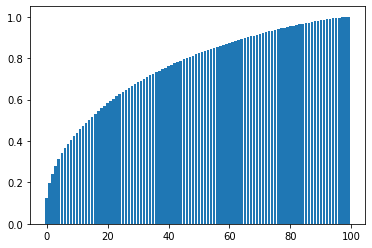

In [184]:
plt.bar(range(100),pca.explained_variance_ratio_.cumsum())

> 주문단위에서 볼때보다는 정보량이 많아졌다.  

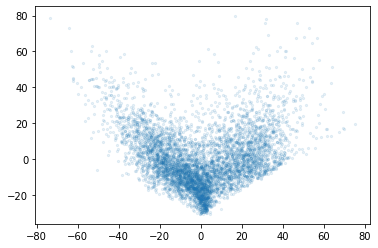

In [187]:
plt.scatter(cst_pca_df[:,0], cst_pca_df[:,1], s = 5, alpha = 0.1)

> 전체 주문량이 고려 되지 않은 것으로 보임..  
얼마나 사느냐가 아니라 무엇을 사느냐를 보는 목적이므로 normalize 필요 

In [248]:
normalizer = Normalizer('max')
norm_cst_item_df = pd.DataFrame(normalizer.fit_transform(cst_item_df), columns = cst_item_df.columns)

In [252]:
norm_cst_item_pca_arr = pca.fit_transform(norm_cst_item_df)

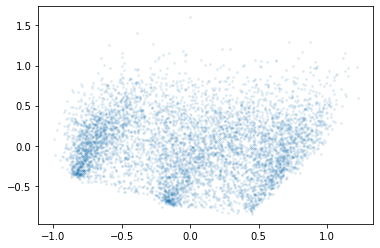

In [255]:
plt.scatter(norm_cst_item_pca_arr[:,0],norm_cst_item_pca_arr[:,1], s = 3, alpha = 0.1)

> 산재되어 있긴 하지만 크게 구매 품목은 3가지 정도의 유형을 보이는 것 같다?

In [267]:
kmeans = KMeans(3)
kmeans.fit(norm_cst_item_pca_arr)
labels = kmeans.predict(norm_cst_item_pca_arr)
norm_cst_item_pca_df = pd.DataFrame(norm_cst_item_pca_arr)
norm_cst_item_pca_df.loc[:,'label'] = labels

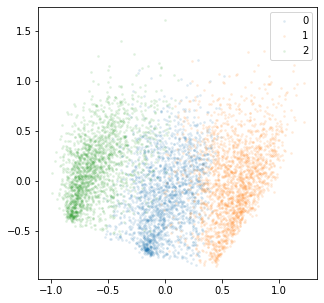

In [273]:
plt.figure(figsize = (5,5))
for i in range(3):
    cst_seg_df = norm_cst_item_pca_df.loc[norm_cst_item_pca_df['label'] == i]
    plt.scatter(cst_seg_df.iloc[:,0], cst_seg_df.iloc[:,1], label = i, s = 3, alpha = 0.1)
    plt.legend()
plt.show()    

> 눈으로 본 것과 비슷한 3개 군집이 표현은 됨. 각 고객의 구매 특성을 어떻게 쪼갤지, 엘보우로 한번 더 체크 하고 진행 

In [275]:
norm_cst_item_pca_df.drop('label', 1, inplace = True)

In [276]:
dist = []
for i in range(1,11):
    st = time.time()
    kmeans = KMeans(i, init = 'k-means++', random_state = 0)
    kmeans.fit(norm_cst_item_pca_df)
    dist.append(kmeans.inertia_)
    sec = round(time.time() - st,2)
    print(f'{i}th Process...({sec}sec)', flush=True)

1th Process...(0.06sec)
2th Process...(0.17sec)
3th Process...(0.37sec)
4th Process...(0.48sec)
5th Process...(0.42sec)
6th Process...(0.43sec)
7th Process...(0.5sec)
8th Process...(0.62sec)
9th Process...(0.61sec)
10th Process...(0.56sec)


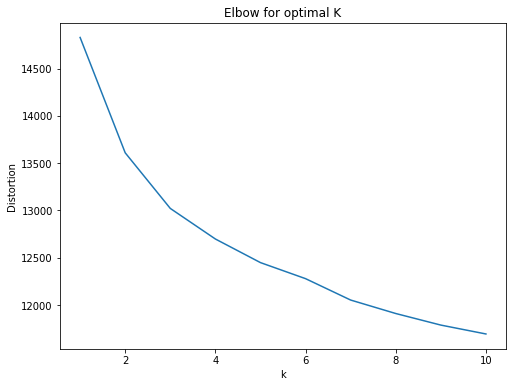

In [298]:
plt.figure(figsize = (8,6))
plt.plot(range(1,11), dist)
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow for optimal K')
plt.show()

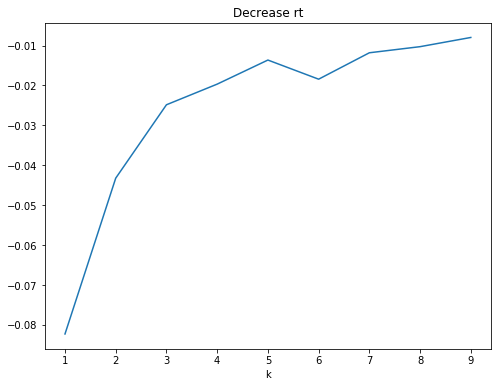

In [299]:
plt.figure(figsize = (8,6))
rt = pd.DataFrame(dist).pct_change()
plt.plot(rt)
plt.xlabel('k')
plt.title('Decrease rt')
plt.show()

> 5가지 고객 유형정도로는 주문내역단위로 나눠볼 수 있을듯?

In [300]:
kmeans = KMeans(5)
kmeans.fit(norm_cst_item_pca_arr)
labels = kmeans.predict(norm_cst_item_pca_arr)
norm_cst_item_pca_df = pd.DataFrame(norm_cst_item_pca_arr)
norm_cst_item_pca_df.loc[:,'label'] = labels

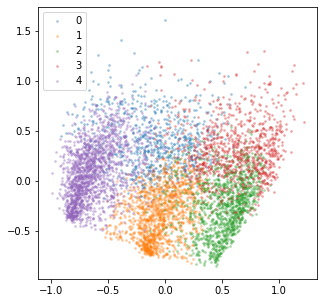

In [302]:
plt.figure(figsize = (5,5))
for i in range(5):
    cst_seg_df = norm_cst_item_pca_df.loc[norm_cst_item_pca_df['label'] == i]
    plt.scatter(cst_seg_df.iloc[:,0], cst_seg_df.iloc[:,1], label = i, s = 3, alpha = 0.3)
    plt.legend()
plt.show()

> 위 5가지 주문내역에 따른 고객유형은 말이 되는 것 같다?  
각 세그먼트별 고객 특성을 지어보자 

In [304]:
cst_pc1_df = pd.DataFrame(pca.components_[0].T, index = ohe_df.columns, columns = ['PC1'])
cst_pc2_df = pd.DataFrame(pca.components_[1].T, index = ohe_df.columns, columns = ['PC2'])

In [308]:
cst_pc1_df.sort_values(by = 'PC1', ascending = False)

,PC1
Bag of Organic Bananas,0.588778
Organic Hass Avocado,0.271196
Organic Strawberries,0.153426
Organic Raspberries,0.136615
Organic Yellow Onion,0.096357
...,...
Cucumber Kirby,-0.060326
Organic Fuji Apple,-0.061687
Strawberries,-0.074611
Organic Avocado,-0.102131


In [309]:
cst_pc2_df.sort_values(by = 'PC2', ascending = False)

,PC2
Organic Strawberries,0.393087
Organic Baby Spinach,0.376770
Organic Hass Avocado,0.316828
Banana,0.294856
Organic Garlic,0.198061
...,...
Organic Half & Half,-0.042027
Spring Water,-0.046055
Soda,-0.049225
Hass Avocados,-0.050921


> x축으로 갈수록 포장바나나를 사는 고객이고, y축으로 갈수록 기타 과일에 가깝다.  
바나나는 다들 그냥 많이 사는거니.. 세그먼트 단위로 좀 봐야겠다 


In [334]:
cst_item_df['label'] = labels
cst_seg_item_df = pd.DataFrame()

In [350]:
cst_item_df['label'] = labels
cst_seg_item_df = pd.DataFrame()
for i in range(5):
    cst_seg_df = cst_item_df.loc[cst_item_df['label'] == i]
    cst_seg_df = cst_seg_df.drop('label', axis = 1)
    top10_items = cst_seg_df.describe().T.sort_values(by = 'mean', ascending = False).head(10)
    seg_items = top10_items.index
    seg_cnts = top10_items['mean'].values
    cst_seg_item_df['{}_item'.format(i)] = seg_items
    cst_seg_item_df['{}_cnt'.format(i)] = seg_cnts

In [351]:
cst_seg_item_df

,0_item,0_cnt,1_item,1_cnt,2_item,2_cnt,3_item,3_cnt,4_item,4_cnt
0,Organic Baby Spinach,13.079622,Organic Whole Milk,5.641975,Bag of Organic Bananas,32.555829,Organic Hass Avocado,23.666300,Banana,35.318986
1,Organic Avocado,10.762483,Organic Strawberries,5.384259,Organic Strawberries,9.419540,Bag of Organic Bananas,18.887665,Organic Strawberries,8.573113
2,Banana,8.947368,Bag of Organic Bananas,3.970679,Organic Baby Spinach,6.261084,Organic Strawberries,15.408590,Organic Baby Spinach,5.968750
3,Large Lemon,8.827260,Half & Half,3.468364,Organic Raspberries,5.795567,Organic Raspberries,9.941630,Organic Whole Milk,5.824882
4,Limes,8.360324,Organic Half & Half,3.423611,Organic Hass Avocado,5.680624,Organic Baby Spinach,9.272026,Organic Avocado,5.620283
5,Organic Strawberries,8.009447,Spring Water,3.396605,Organic Whole Milk,5.041872,Organic Lemon,6.940529,Strawberries,4.692807
6,Organic Garlic,7.395412,Organic Baby Spinach,3.280864,Organic Large Extra Fancy Fuji Apple,3.749589,Organic Yellow Onion,6.823789,Organic Fuji Apple,4.408019
7,Organic Yellow Onion,5.925776,Sparkling Water Grapefruit,3.245370,Organic Yellow Onion,3.610016,Apple Honeycrisp Organic,5.693833,Organic Hass Avocado,4.208726
8,Organic Zucchini,5.010796,Organic Hass Avocado,3.092593,Apple Honeycrisp Organic,3.221675,Organic Garlic,5.213656,Large Lemon,4.050118
9,Carrots,4.346829,Strawberries,3.066358,Organic Garlic,3.104269,Organic Cucumber,4.977974,Honeycrisp Apple,3.587264


> 해석하기 위해 다시 차트랑 비교 

- 4번 세그먼트(보라) : 바나나를 사러 들어오는게 주 목표인 고객, 바나나 외 다른걸 사는 빈도는 그냥 저냥..  포장바나나는 구매하지 않음. 
- 3번 세그먼트(빨강) : 바나나나 포장바나나가 주가 아닌 고객, 아보카도를 선호함.  기타 과일이나 포장바나나도 가끔 구매. 바나나는 구매하지 않음. 
- 2번 세그먼트(초록) : 4번과 굉장히 유사하지만 바나나가 포장바나나로 대체된 고객군  
- 1번 세그먼트(노랑) : 바나나에 별로 관심이 없는 고객. 구매량도 적고 우유를 가장 많이 구매함  
- 0번 세그먼트(파랑) : 1번 세그먼트와 비슷하지만 1번 세그먼트가 포장바나나를 구매했다면 0번 세그먼트는 바나나를 선호하는 편.  

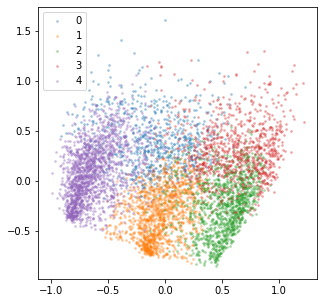

In [333]:
plt.figure(figsize = (5,5))
for i in range(5):
    cst_seg_df = norm_cst_item_pca_df.loc[norm_cst_item_pca_df['label'] == i]
    plt.scatter(cst_seg_df.iloc[:,0], cst_seg_df.iloc[:,1], label = i, s = 3, alpha = 0.3)
    plt.legend()
plt.show()

> 0번 세그먼트는 큰 특징이 없음

In [326]:
cst_seg_df.describe().T.sort_values(by = 'mean', ascending = False).head(10).index

Index(['Organic Baby Spinach', 'Organic Avocado', 'Banana', 'Large Lemon',
       'Limes', 'Organic Strawberries', 'Organic Garlic',
       'Organic Yellow Onion', 'Organic Zucchini', 'Carrots'],
      dtype='object')

### 3-10. 구매 패턴에 따라 고객군을 좀 더 나눠본다면?  
> 고객별 구매요일이나 주기가 특정 패턴을 보이는 것 같지는 않음.  

In [363]:
for c in ['week_day','order_hour']:
    cst_base_df[c] = cst_base_df[c].astype('int')
cst_time_df = pd.pivot_table(cst_base_df, index = ['cstno','order_id'], values = ['order_interval','week_day','order_hour'], aggfunc = 'mean')

In [395]:
weekday_le = LabelEncoder()
weekday_ohe = OneHotEncoder(sparse = False)

In [401]:
cst_weekday_df = pd.DataFrame(weekday_ohe.fit_transform(weekday_le.fit_transform(cst_time_df['week_day']).reshape(-1,1)), columns = weekday_le.classes_).astype('int')

In [402]:
cst_time_df = pd.concat([cst_time_df, cst_weekday_df], 1) 

In [404]:
cst_time_df.columns = ['cstno','order_id','order_hour','order_interval','week_day','sun','mon','tue','wed','thu','fri','sat']
cst_time_df.drop('week_day', axis = 1, inplace = True)

In [405]:
cst_time_df

,cstno,order_id,order_hour,order_interval,sum,mon,tue,wed,thu,fri,sat
0,10000,12156,20,1,0,0,0,1,0,0,0
1,10000,103998,6,6,0,0,0,1,0,0,0
2,10000,192826,13,6,1,0,0,0,0,0,0
3,10000,193643,7,10,1,0,0,0,0,0,0
4,10000,236049,9,7,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
341673,99901,3264185,10,8,0,0,0,0,1,0,0
341674,99901,3270614,15,5,0,0,0,1,0,0,0
341675,99901,3293557,13,6,0,0,0,0,0,0,1
341676,99901,3369192,16,13,0,0,0,0,1,0,0


In [366]:
cst_time_df.reset_index(inplace = True)

In [417]:
cst_time_pivot = pd.pivot_table(cst_time_df, index = 'cstno', values = ['order_interval','order_hour','sun','mon','tue','wed','thu','fri','sat'], aggfunc = ['mean'])['mean']

In [418]:
cst_time_pivot

,fri,mon,order_hour,order_interval,sat,sum,thu,tue,wed
cstno,,,,,,,,,
10000,0.121212,0.166667,11.363636,4.621212,0.136364,0.227273,0.121212,0.136364,0.090909
100001,0.142857,0.206349,12.952381,5.365079,0.047619,0.047619,0.095238,0.253968,0.206349
100046,0.112903,0.177419,14.612903,4.612903,0.209677,0.145161,0.096774,0.145161,0.112903
100071,0.039216,0.392157,13.784314,5.431373,0.078431,0.156863,0.098039,0.098039,0.137255
100108,0.126984,0.238095,12.571429,5.238095,0.031746,0.222222,0.158730,0.111111,0.111111
...,...,...,...,...,...,...,...,...,...
9981,0.770833,0.062500,11.500000,7.104167,0.000000,0.020833,0.104167,0.041667,0.000000
99829,0.046512,0.069767,13.534884,8.302326,0.534884,0.348837,0.000000,0.000000,0.000000
99887,0.168539,0.191011,14.573034,3.910112,0.134831,0.101124,0.112360,0.112360,0.179775


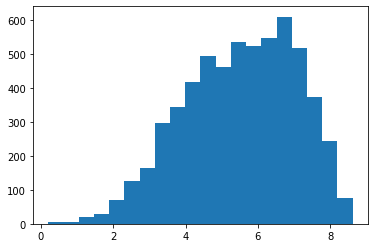

In [378]:
plt.hist(cst_time_pivot['mean','order_interval'], bins = 20)
plt.show()

> 평균적으로 일주일에 한번정도 주문을 하는것 같고, 최소 주문이 40번이상씩이었으니깐 패턴으로 인식할 가능성 높음  
구매 주기와 구매요일, 구매 시간을 놓고 다시 한번 세그먼트 생성

> order interval 과 order hour는 표준화 좀 시키고 

In [437]:
mm_scaler = MinMaxScaler()

In [442]:
cst_time_pivot['adj_order_hour'] = mm_scaler.fit_transform(cst_time_pivot['order_hour'].values.reshape(-1,1))
cst_time_pivot['adj_order_interval'] = mm_scaler.fit_transform(cst_time_pivot['order_interval'].values.reshape(-1,1))

In [444]:
cst_time_pivot.drop(['order_hour','order_interval'], axis = 1, inplace = True)

In [445]:
pca = PCA()

In [452]:
cst_time_pivot_pca = pca.fit_transform(cst_time_pivot)

<BarContainer object of 9 artists>

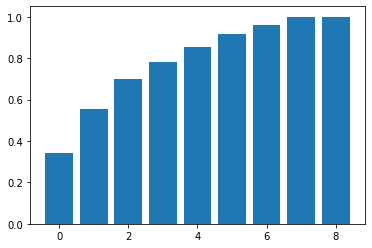

In [451]:
variance_ratio = pca.explained_variance_ratio_.cumsum()
plt.bar(range(9),variance_ratio)

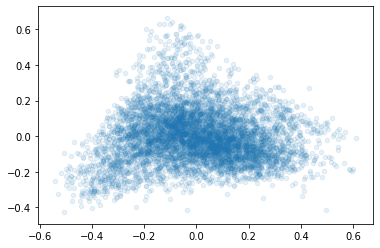

In [457]:
plt.scatter(cst_time_pivot_pca[:,0], cst_time_pivot_pca[:,1], alpha = 0.1, s = 20)
plt.show()

> 구매 패턴의 2차 pc까지에서는 눈으로 보이는건 없는 듯  
시점은 고객별 정보로 적당히.. 봐봐야겠다  

### 3-11. 뭐 좀 더 볼만한거 없을까? 
> 상품간 관계?

## 4. 분석 설계 및 변수 가공

## 4. 분석 설계 및 변수 가공

## 4. 분석 설계 및 변수 가공